new plan!! first part: separate parts of images with cars. then check
if they have letters ?


1) get license plate images
    1.1) separate cars from image
    1.2) check sub images for plates
    1.3) threshold to make into nice plate image
2) split into letters (segment)
3) pass into (pre-trained?) cnn to recognise letters (one at a time! order matters)

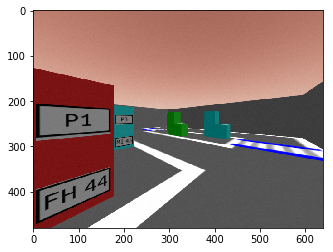

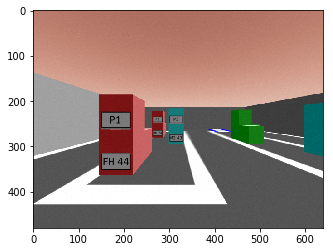

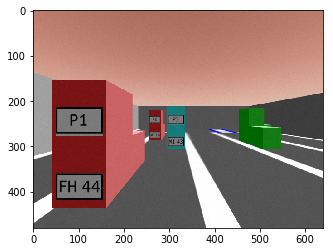

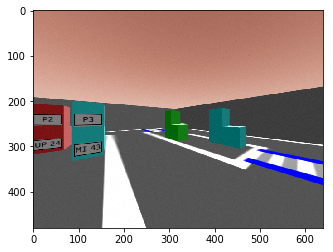

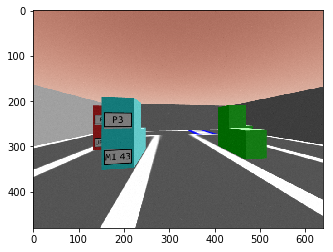

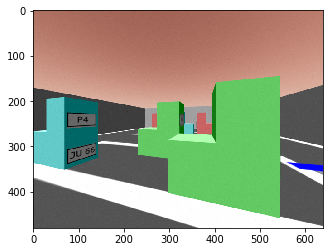

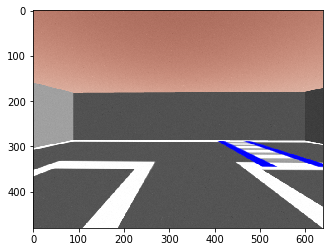

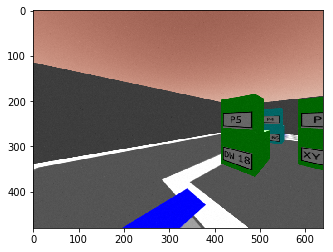

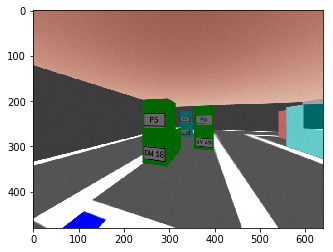

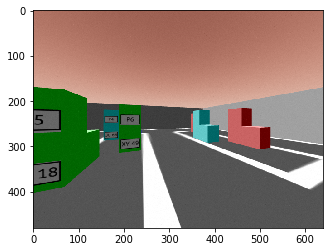

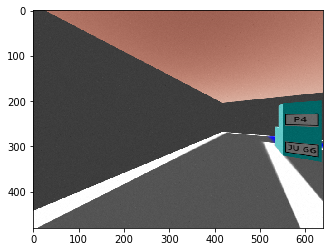

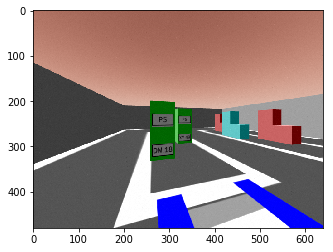

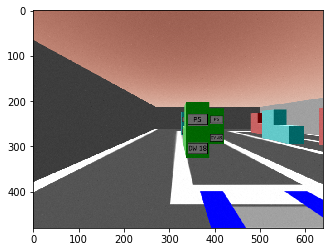

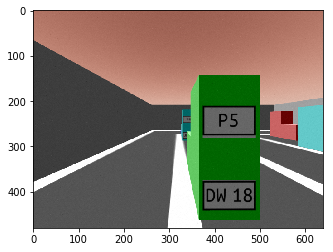

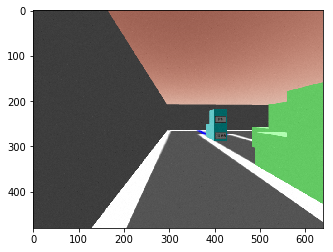

In [80]:
# get image from robot.

import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import statistics as sts

# get path to this directory
path = os.getcwd() + "/test_imgs/"  # gets current working directory. is "hacky" (replace this with os.path or smth on vs)

# to start, only this one:
test_img = []
for i in range(4,19):
    temp = cv2.imread(path + "test{}.png".format(i))
    test_img.append(temp)
    plt.imshow(temp)
    plt.show()

# TODO change this to get many license plates

In [ ]:
# divide into sub-images with cars


## segment image ##
1) Convert to greyscale, then threshold to get clearer letters

2) Process to make sure there arent any false positives
    - blur
    - ?? hopefully it will be good after the blur
    
3) Get vertical total (or average or whatever) pixel val
    - if it is under a certain threshold, theres no letter there
    
4) Chop up image

avg pix val: 106.885410156
threshold: 32.3895182292


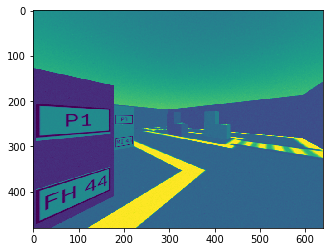

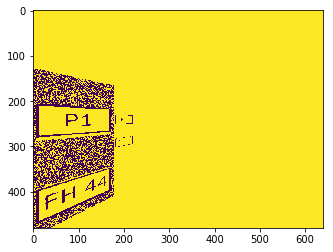

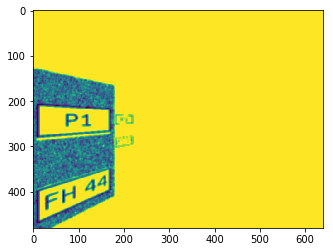

avg pix val: 123.579583333
threshold: 37.4483585859


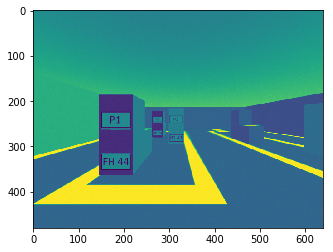

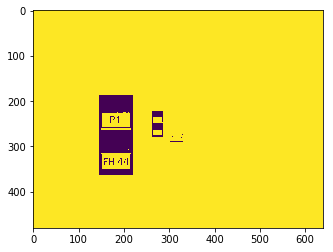

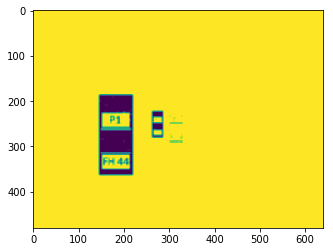

avg pix val: 112.686197917
threshold: 34.147332702


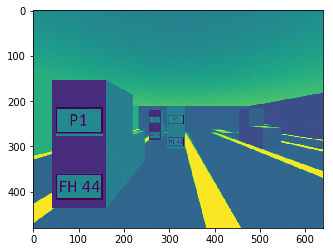

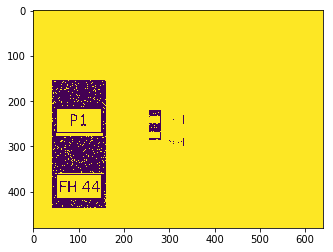

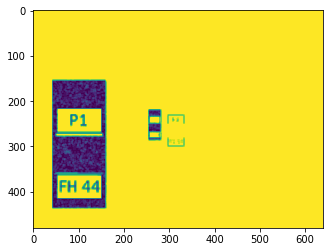

avg pix val: 115.117190755
threshold: 34.8839971985


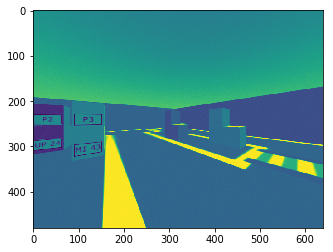

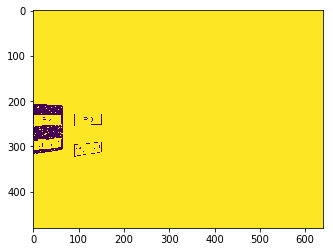

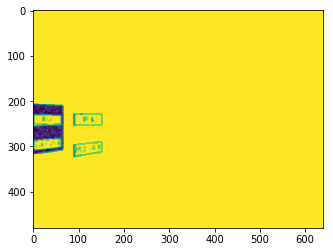

avg pix val: 120.204869792
threshold: 36.4257181187


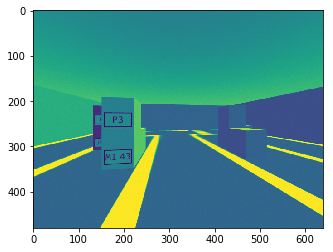

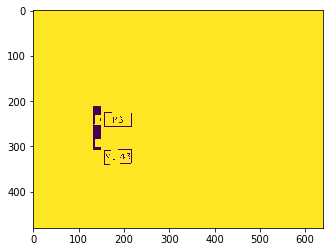

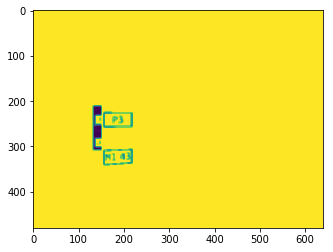

avg pix val: 137.088408203
threshold: 41.5419418797


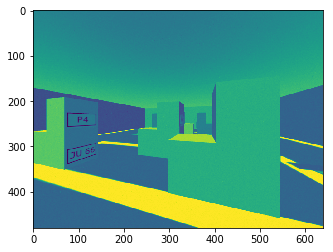

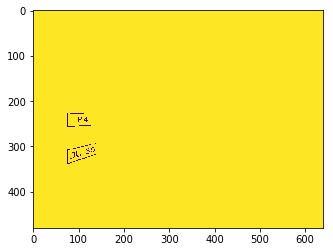

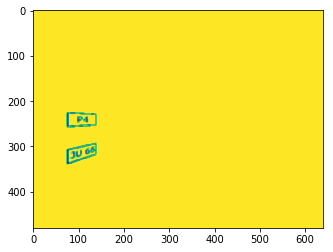

avg pix val: 118.479010417
threshold: 35.9027304293


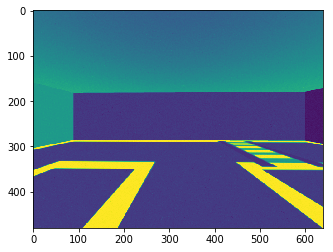

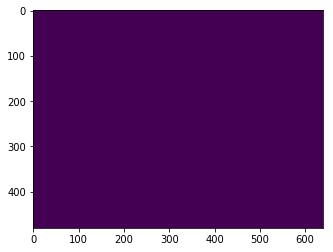

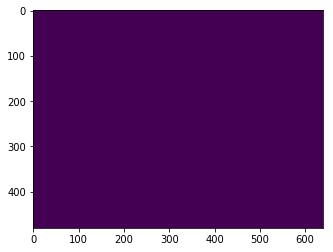

avg pix val: 99.5948209635
threshold: 30.1802487768


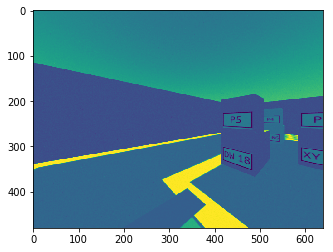

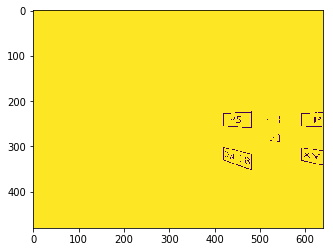

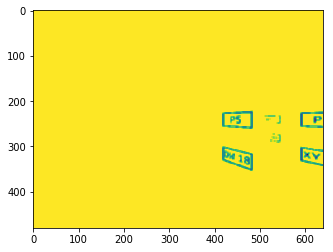

avg pix val: 113.937529297
threshold: 34.5265240294


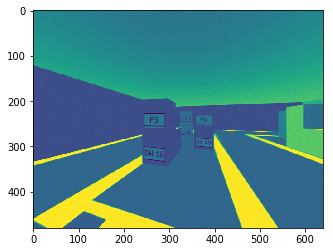

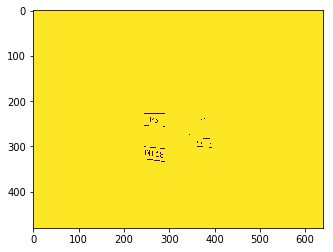

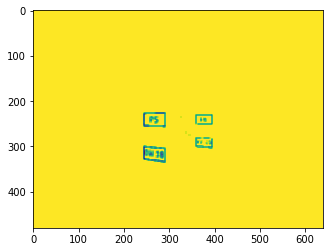

avg pix val: 114.674335938
threshold: 34.7497987689


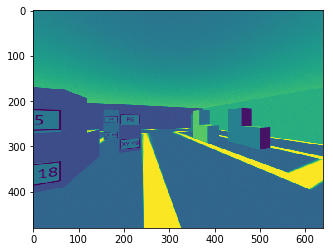

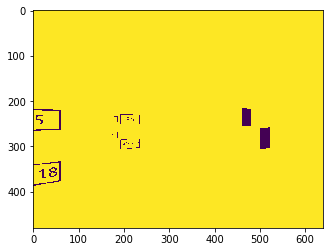

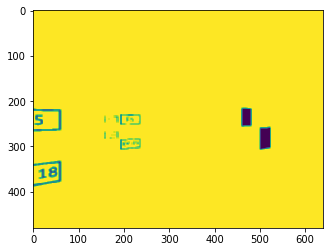

avg pix val: 97.3297526042
threshold: 29.4938644255


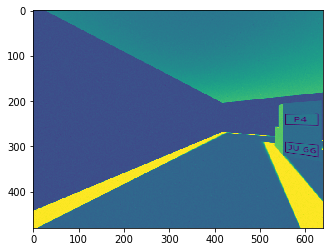

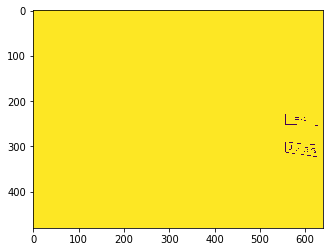

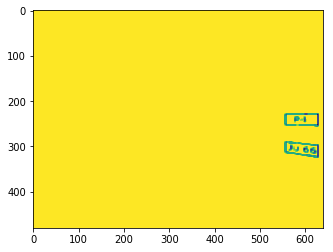

avg pix val: 118.715917969
threshold: 35.9745205966


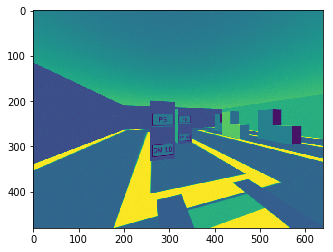

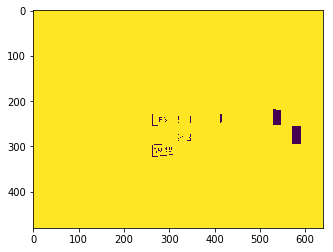

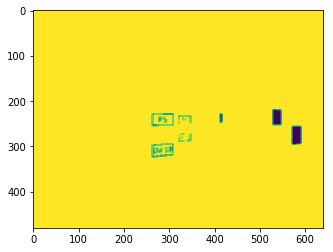

avg pix val: 112.55703776
threshold: 34.1081932607


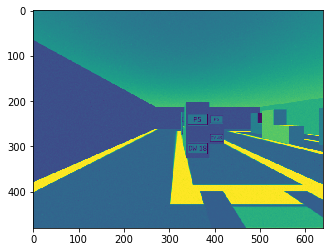

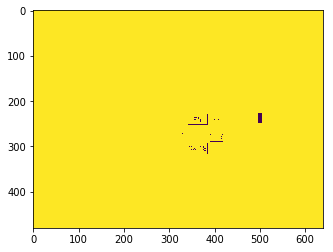

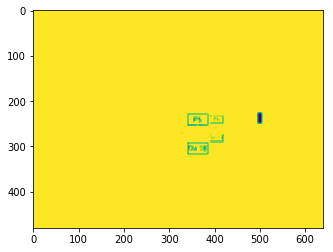

avg pix val: 103.708395182
threshold: 31.4267864189


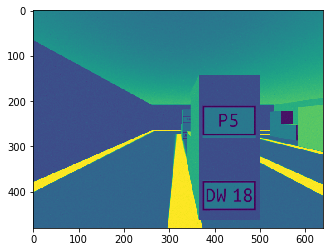

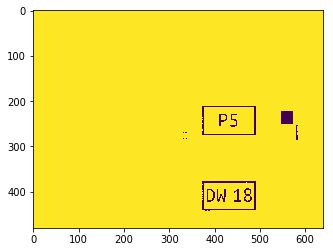

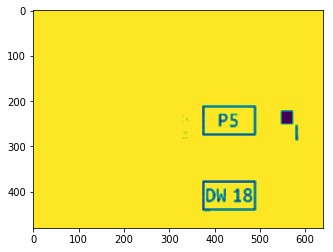

avg pix val: 102.472955729
threshold: 31.052410827


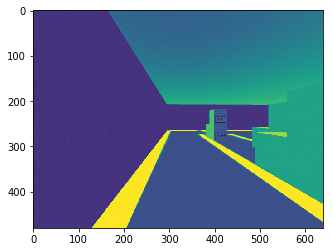

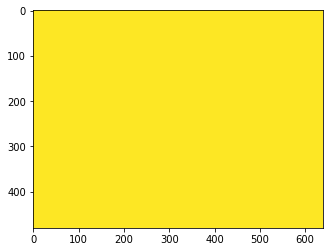

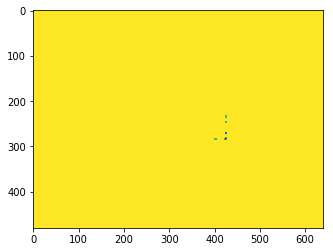

In [113]:
# 1) Convert to greyscale, threshold
grey_img_list = []
blur_img_list = []
bin_img_list = []
for img in test_img:
    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grey_img_list.append(grey_img)

    apv = np.mean(grey_img)
    print("avg pix val: {}".format(apv))

    threshold = apv/3.3 # starts to have more dark space around 4
    print("threshold: {}".format(threshold))

    _, img_bin = cv2.threshold(grey_img, threshold, 255, cv2.THRESH_BINARY)
    bin_img_list.append(img_bin)

    plt.imshow(grey_img)
    plt.show()

    plt.imshow(img_bin)
    plt.show()

    # 2) Blur image to get rid of freckles
    blur_img = cv2.blur(img_bin, (5,5))
    blur_img_list.append(blur_img)

    plt.imshow(blur_img)
    plt.show()

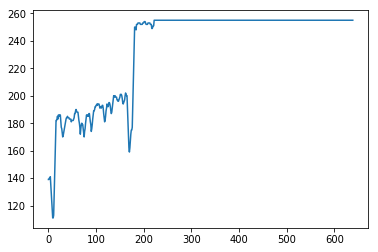

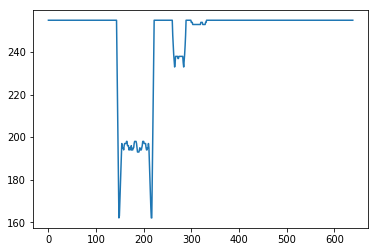

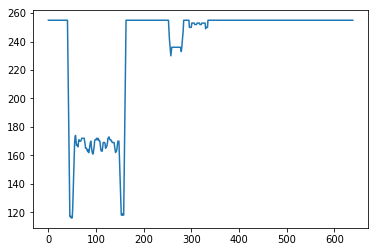

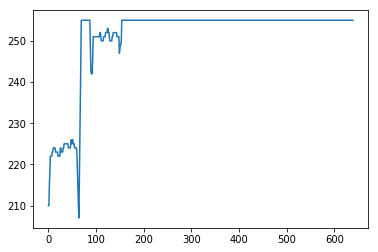

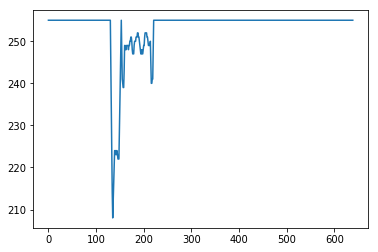

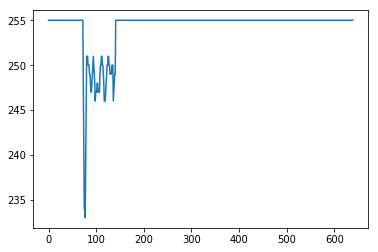

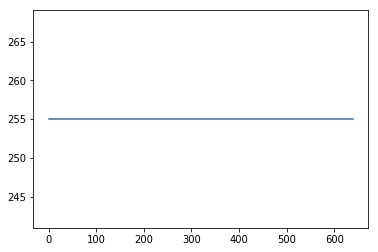

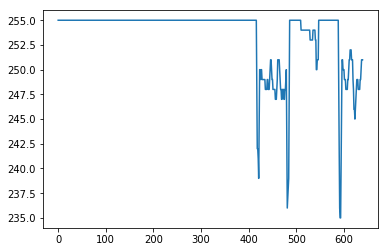

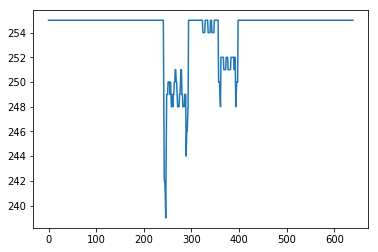

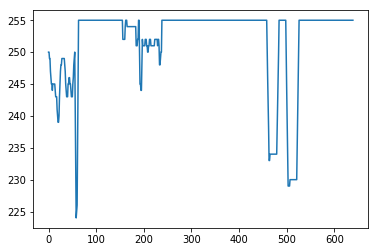

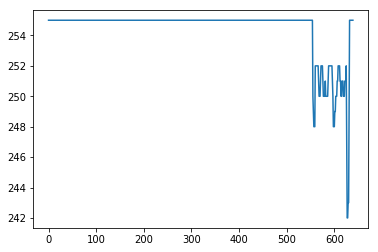

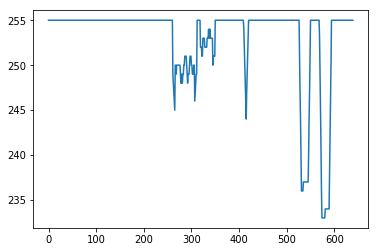

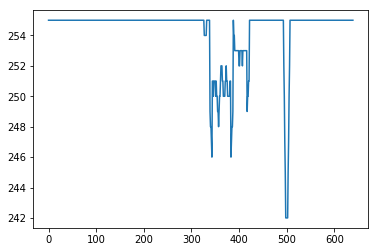

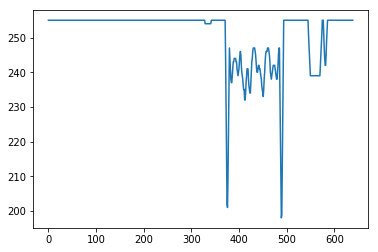

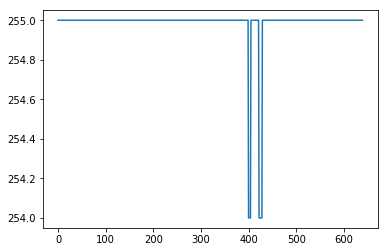

In [114]:
# 3) Get vertical pixel value 
pix_vals_list = []

for blur_img in blur_img_list:
    h, w = blur_img.shape

    pix_vals = []

    for i in range(w):
        pix_sum = 0
        for j in range(h):
            pix_sum += blur_img[j,i]
        pix_vals.append(pix_sum/h)

    pix_vals_list.append(pix_vals)
    plt.plot(range(w), pix_vals)
    plt.show()

In [115]:
# 4) Segment image
chunks_v_list = []
# 255 is white space
for pix_vals in pix_vals_list:
    mode_val = sts.mode(pix_vals)
    avg_val = sts.mean(pix_vals)
    
    t_mod = 0
    avg_mod = 3
    # normalizing it... (255-avg_val)*avg_mod/255 should = 0 when the average is 255(white space), so we want s_t = m_v
    space_thresh = mode_val - abs(mode_val-avg_val)*(255-avg_val)*avg_mod/255 - t_mod
    # print("avg: {}".format(avg_val))
    # print("mode: {}".format(mode_val))
    # print("thresh: {}".format(space_thresh))

    # maybe if it doesn't find, try again with lower thresh or smth

    # need to get places where it dips out of white space, but leave 
    # a bit on the sides?



    chunks_v = []
    i = 0
    keep_going = False
    while i in range(len(pix_vals)):
        if(pix_vals[i] < space_thresh):

            if not keep_going:
                start = i

            while(pix_vals[i] < space_thresh):
                # print(j)
                i += 1
                if i not in range(len(pix_vals)):
                    break
            if(abs(start-i) > 10):  # maybe change this 2 --> 10 or smth
                chunks_v.append([start, i])
                keep_going = False
            else:
                keep_going = True
                # print("and i oop")
                # print(i)

        i += 1


    chunks_v_list.append(chunks_v)
    # print(chunks_v)
    # print

image 0: 2
image 1: 3
image 2: 3
image 3: 2
image 4: 2
image 5: 1
image 6: 0
image 7: 3
image 8: 3
image 9: 5
image 10: 1
image 11: 4
image 12: 3
image 13: 3
image 14: 1
image 0


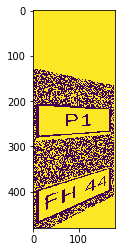

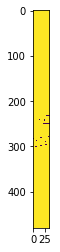

image 1


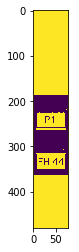

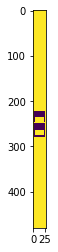

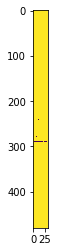

image 2


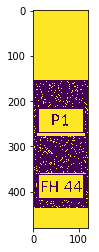

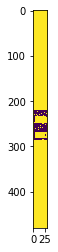

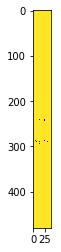

image 3


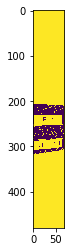

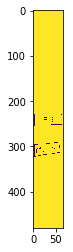

image 4


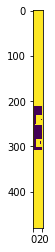

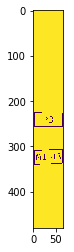

image 5


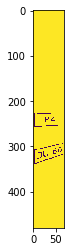

image 6
image 7


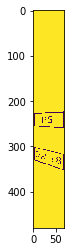

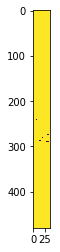

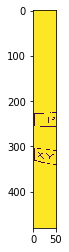

image 8


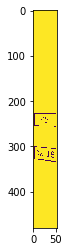

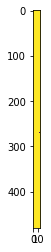

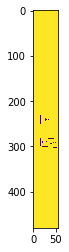

image 9


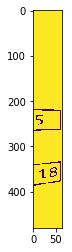

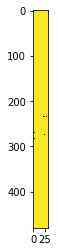

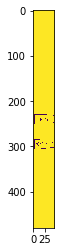

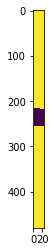

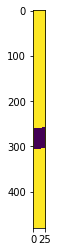

image 10


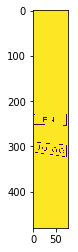

image 11


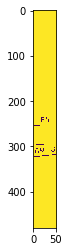

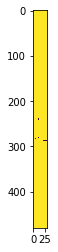

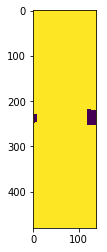

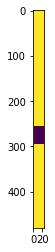

image 12


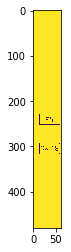

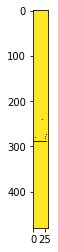

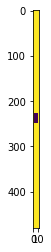

image 13


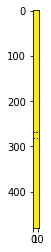

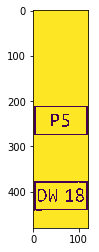

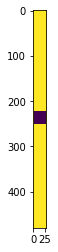

image 14


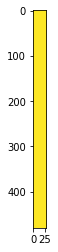

In [116]:
# print the image segments to see if its working
for j in range(len(grey_img_list)):
    print("image {}: {}".format(j, len(chunks_v_list[j])))
for j in range(len(grey_img_list)):
    temp_imgs = []
    temp_img_grey = []
    print("image {}".format(j))
    for i in range(len(chunks_v_list[j])):
        temp_imgs.append(bin_img_list[j][:, chunks_v_list[j][i][0]:chunks_v_list[j][i][1]])
        temp_img_grey.append(grey_img_list[j][:, chunks_v_list[j][i][0]:chunks_v_list[j][i][1]])
        plt.imshow(temp_imgs[i])
        plt.show()

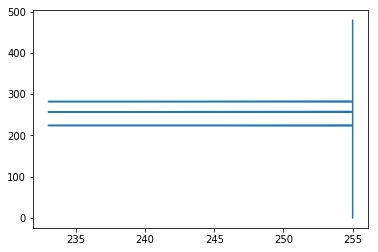

mode: 255
[[224, 258]]


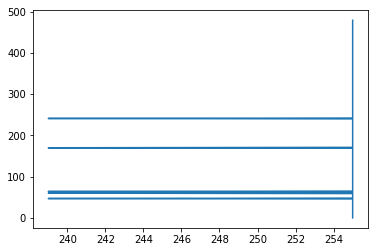

mode: 255
[[47, 61], [64, 171]]


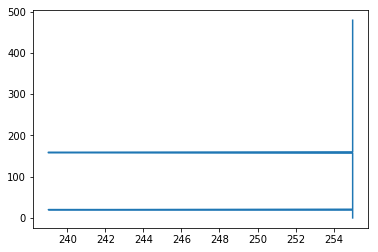

mode: 255
[[20, 160]]


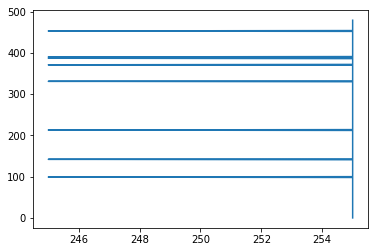

mode: 255
[[99, 143], [213, 332], [371, 388], [390, 454]]


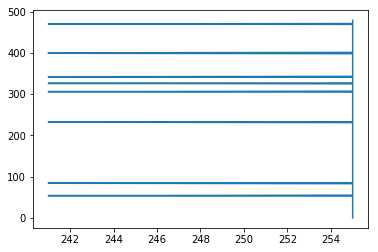

mode: 255
[[54, 85], [232, 307], [326, 343], [399, 471]]


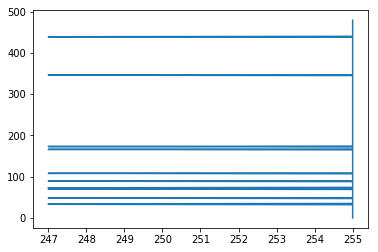

mode: 255
[[33, 49], [70, 90], [108, 167], [173, 347]]


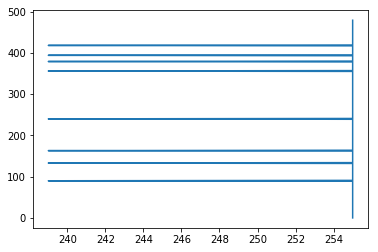

mode: 255
[[90, 134], [163, 241], [356, 380], [394, 419]]


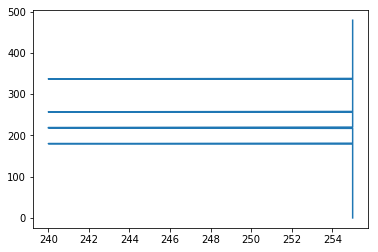

mode: 255
[[180, 220], [257, 338]]


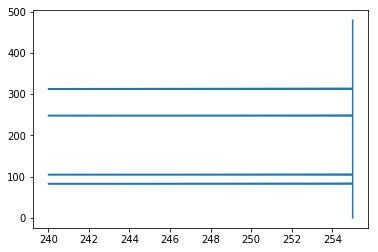

mode: 255
[[83, 106], [248, 314]]


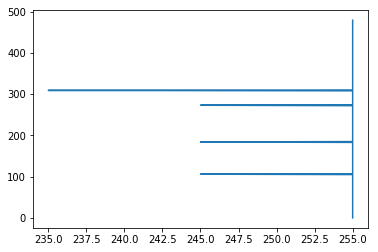

mode: 255
[[106, 185], [273, 310]]


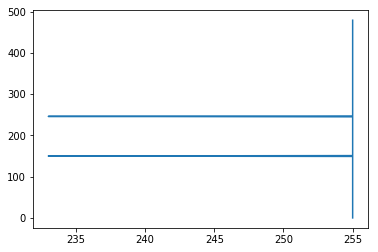

mode: 255
[[150, 247]]


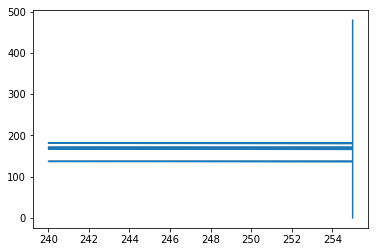

mode: 255
[[137, 168], [171, 182]]


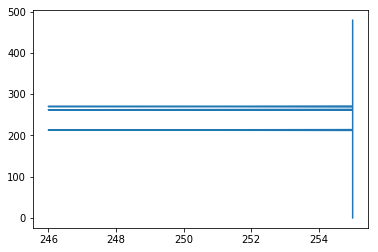

mode: 255
[[213, 263]]


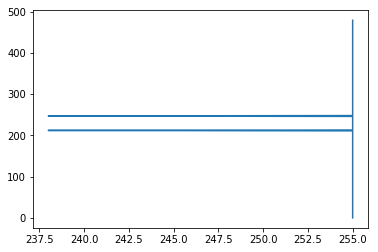

mode: 255
[[212, 248]]


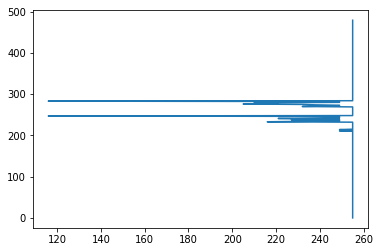

mode: 255
[[211, 248], [270, 284]]


In [98]:

chunks_h = []
for temp_img in temp_imgs:
    # do the same thing but horizontally
    h2, w2 = temp_img.shape

    pix_vals = []

    for i in range(h2):
        pix_sum = 0
        for j in range(w2):
            pix_sum += temp_img[i,j]
        pix_vals.append(pix_sum/w2)

    plt.plot(pix_vals, range(h2))
    plt.show()

    temp_c = []
    space_thresh = sts.mode(pix_vals)
    print("mode: {}".format(space_thresh))
    i = 0
    keep_going = False
    while i in range(len(pix_vals)):
        if(pix_vals[i] < space_thresh):
            
            if not keep_going:
                start = i

            while(pix_vals[i] < space_thresh):
                # print(j)
                i += 1
                if i not in range(len(pix_vals)):
                    break
            if(abs(start-i) > 5):  # maybe change this 2 --> 10 or smth
                temp_c.append([start, i])
                keep_going = False
            else:
                keep_going = True

        i += 1
        
    if len(temp_c) >= 1:
        chunks_h.append(temp_c)
        print(temp_c)             
        

[[130, 480]]
PLATE SET 0


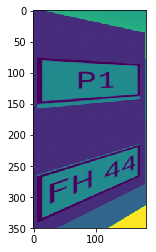

[[231, 245], [249, 290], [292, 302]]
PLATE SET 1


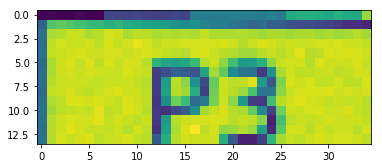

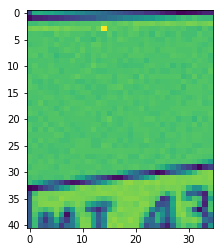

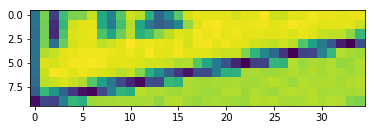

In [228]:
# get image portions from those chunks
# temp_img_grey is list of vertical strips (done above)

plate_imgs = []
for j in range(len(chunks_h)):  # each vertical strip should be kept as a pair
    temp = []
    print(chunks_h[j])
    print("PLATE SET {}".format(j))
    for i in range(len(chunks_h[j])): # cut horizontally
        temp.append(temp_img_grey[j][chunks_h[j][i][0]:chunks_h[j][i][1], :])
        plt.imshow(temp[i])
        plt.show()
    
    plate_imgs.append(temp)



mean: 68.1486763267
13.629735265346051


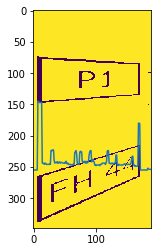

[[7, 18], [28, 56], [66, 72], [74, 98], [110, 115], [116, 134], [156, 160], [168, 171]]


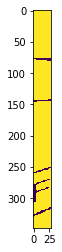

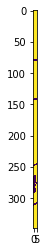

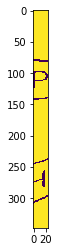

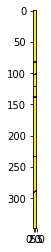

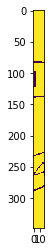

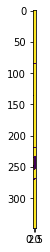

In [142]:
# now get them into images!! same method lol
import statistics as sts

plates_separated = [] # will be 2D list with [[P, P, A, A, #, #], [...], etc]

# 255 is white space
thresh2 = 0  # this is changed later for some reason it doesn't work unless its also here

count = 0
for plate in plate_imgs: 
    print("mean: {}".format(np.mean(plate)))
    thresh2 = np.mean(plate)/5
    print(thresh2)

    _, plate_bin = cv2.threshold(plate, thresh2, 255, cv2.THRESH_BINARY)
    h2, w2 = plate_bin.shape
    plt.imshow(plate_bin)
    plt.plot()
    
    pix_vals = []

    for i in range(w2):
        pix_sum = 0
        for j in range(h2):
            pix_sum += plate_bin[j,i]
        pix_vals.append(pix_sum/h2)

    plt.plot(range(w2), pix_vals)
    plt.show()
    
    pix_vals_mode = sts.mode(pix_vals)
    space_thresh_2 = pix_vals_mode 
    chunks = [] 
    i = 0
    while i in range(len(pix_vals)):
        if(pix_vals[i] < space_thresh_2):
            start = i
            while(pix_vals[i] < space_thresh_2):
                # print(j)
                i += 1
                if i not in range(len(pix_vals)):
                    break
            
            if(abs(start-i) > 2):  # maybe change this 2 --> 10 or smth
                chunks.append([start, i])
    
        i += 1

    print(chunks)
    temp = []
    for i in range(1, len(chunks)-1):
        temp.append(plate_bin[:, chunks[i][0]:chunks[i][1]])
        plt.imshow(temp[i-1])
        plt.show()
    
    plates_separated.append(temp)
